# Data Fusion1 Contest 2024 - Задача 2 «Отток»
https://ods.ai/competitions/data-fusion2024-churn

Данные:
1. Табличные клиентские данные:
Участникам доступны несколько наборов данных и артефактов:   
- Базовая информация про все 96,000 клиентов в табличном .csv формате: clients.csv (2.5 MB)
- Тренировочные данные по целевой переменной и времени последней транзакции для 64,000 клиентов: train.csv (745 KB)
- Информация об отчетах, в рамках которых клиенты сгруппированы по времени: report_dates.csv (288 KB)
2. Данные клиентских транзакций:  
- Клиентские транзакции для всех 96,000 клиентов (~13М) в табличном  .csv  формате:  transactions.csv.zip (197 MB)

In [1]:
# !pip install lifelines
# !pip install threadpoolctl==3.1.0
# !pip install openpyxl -U

### TODO:
- Добавить/Убрать группы mcc  
- Увеличить число pop_mcc  
- Поменять долллар и евро, проверить  
- Перевести мсс код в категориальные признаки, а не числовые  


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from scipy.stats import skew, mode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Включаем tqdm для pandas, чтобы можно было запускать progress_apply() вместо простого apply()
tqdm.pandas() 
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

# Загружаем данные

In [5]:
PATH = ''
DATASETS_PATH = PATH + 'datasets/'

In [7]:
clients_df = pd.read_csv(DATASETS_PATH +  'clients.csv')
src_train_df = pd.read_csv(DATASETS_PATH +  'train.csv')
report_dates_df = pd.read_csv(DATASETS_PATH + 'report_dates.csv')
transactions_df = pd.read_csv(DATASETS_PATH + 'transactions.csv')
currency_df = pd.read_csv(DATASETS_PATH + 'currency_rk.csv')

clients_df.shape, src_train_df.shape, report_dates_df.shape, transactions_df.shape, currency_df.shape

((96000, 5), (64000, 3), (12, 2), (13075023, 5), (3, 2))

In [ ]:
# 320 in src_train_df['user_id'].unique()
# 320 in transactions_df['user_id'].unique()
# clients_df.shape

In [9]:
# Загружаем курсы валют
# Курсы валют за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/
# График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/
# Тип используемой валюты
# 1 — рубль
# 2,3 — евро и доллар 
# 0 — все остальное
# Возьмем за 0 белорусский рубль, потому что: 
#   1. он является 3ей самой популярной валютой в Россиии после доллара и евро (https://www.rbc.ru/finances/15/11/2019/5dce1f329a794794883bd4fa)
#   2. курс бел.рубля ~30 руб, что попадает в диапозон 20-40 рублей за большинство других валют
dollar_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/dollar_RC_F01_01_2021_T06_03_2024.xlsx')
euro_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/euro_RC_F01_01_2021_T06_03_2024.xlsx')
belarus_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/belarus_RC_F01_01_2021_T06_03_2024.xlsx')
# Загружаем инфляцию
# Например с января 2021 года по января 2024 года рубль инфляция съела 0,3 рубля
inflation_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/inflation.xlsx').rename(columns={'Месяц': 'month', 'Год': 'year'})

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Предварительная обработка

In [12]:
# employee_count_nm - кодируем по возрастанию, т.к. природа фичи подразумевает ранговое представление 
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].fillna('НЕТ')
clients_df['employee_count_nm_code'] = clients_df['employee_count_nm'].replace({
    'НЕТ': 0,
    'ДО 10': 1, 
    'ОТ 11 ДО 30': 2,
    'ОТ 11 ДО 50': 3,
    'ОТ 31 ДО 50': 4,
    'ОТ 51 ДО 100': 5,
    'ОТ 101 ДО 500': 6, 
    'БОЛЕЕ 500': 7,
    'ОТ 501 ДО 1000': 8, 
    'БОЛЕЕ 1001': 9, 
}).fillna(0)

clients_df = clients_df.merge(report_dates_df, on='report', how='left')
clients_df.shape
# clients_df['employee_count_nm'].value_counts(dropna=False)

C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\858624661.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clients_df['employee_count_nm_code'] = clients_df['employee_count_nm'].replace({


(96000, 7)

In [13]:
# Обрабатываем даты
dates = pd.to_datetime(transactions_df['transaction_dttm']).dt

In [14]:
# Формируем фичи из даты и времени
transactions_df['date'] = dates.date
transactions_df['weekday'] = dates.weekday
transactions_df['year'] = dates.year
transactions_df['month'] = dates.month
transactions_df['hour'] = dates.hour
# Выходные
transactions_df['is_holiday'] = np.where(transactions_df['weekday'].isin([5, 6]), 1, 0)
# Определяем период начала или конца года
transactions_df['end_of_year'] = np.where(transactions_df['month'].isin([11,12]), 1, 0)
transactions_df['begin_of_year'] = np.where(transactions_df['month'].isin([1,2]), 1, 0)
# Время года
transactions_df['season_of_year'] = np.where(
                    transactions_df['month'].isin([12, 1, 2]), 'winter', 
                    np.where(transactions_df['month'].between(3,5), 'spring',
                        np.where(transactions_df['month'].between(6,8), 'summer', 'fall')
                            )
                    )
# Время дня
transactions_df['time_of_day'] = np.where(
                    transactions_df['hour'].between(0, 4), 'night', 
                    np.where(transactions_df['hour'].between(5, 9), 'morning',
                        np.where(transactions_df['hour'].between(10,18), 'day', 'evening')
                            )
                    )
transactions_df.shape

(13075023, 15)

### Нормализация цен
- инфляция за период с 2021 по 2023  
- курс доллара и евро с 2021 по 2023  
- курс "другой" валюты

Курс доллара и евро с 2021 по 2024 за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/  
График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/  


Тип валюты:   
1 — рубль    
2,3 — евро и доллар     
0 — все остальное  

In [16]:
dollar_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in dollar_curs_df[['data', 'curs']].to_dict('split')['data']}
eu1o_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in euro_curs_df[['data', 'curs']].to_dict('split')['data']}
belarus_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in belarus_curs_df[['data', 'curs']].to_dict('split')['data']}

inflation_dict = {}
for y, m, c in inflation_df[['year', 'month', 'cumulative_inflation']].to_dict('split')['data']:
    if y not in inflation_dict:
        inflation_dict[y] = {}
    inflation_dict[y][m] = c

In [17]:
dollar_curs_df['year'] = dollar_curs_df['data'].dt.year
dollar_curs_df['month'] = dollar_curs_df['data'].dt.month

euro_curs_df['year'] = euro_curs_df['data'].dt.year
euro_curs_df['month'] = euro_curs_df['data'].dt.month

belarus_curs_df['year'] = belarus_curs_df['data'].dt.year
belarus_curs_df['month'] = belarus_curs_df['data'].dt.month

def create_money_dict(df:pd.DataFrame):
    money_dict = {}
    for y, m, c in df.reset_index()[['year', 'month', 'curs']].to_dict('split')['data']:
        if y not in money_dict:
            money_dict[y] = {}
        money_dict[y][m] = c
    return money_dict

dollar_curs_dict = create_money_dict(dollar_curs_df.groupby(by=['year', 'month'])['curs'].mean())
euro_curs_dict = create_money_dict(euro_curs_df.groupby(by=['year', 'month'])['curs'].mean())
belarus_curs_dict = create_money_dict(belarus_curs_df.groupby(by=['year', 'month'])['curs'].mean())
inflation_dict = create_money_dict(inflation_df[['year', 'month', 'cumulative_inflation']].rename(columns={'cumulative_inflation': 'curs'}))



In [18]:
# Нормализация цен
def amt_normalize(x):
    normal_amt = x.transaction_amt
    # Приводим валюту к рублям
    if x.currency_rk == 2:
        normal_amt = normal_amt * euro_curs_dict[x.year][x.month]
    elif x.currency_rk == 3:
        normal_amt = normal_amt * dollar_curs_dict[x.year][x.month]
    elif x.currency_rk == 0:
        normal_amt = normal_amt * belarus_curs_dict[x.year][x.month]
    # Нормируем к инфляции рублевой
    normal_amt = normal_amt * inflation_dict[x.year][x.month]
    return normal_amt

transactions_df['normal_transaction_amt'] = transactions_df.progress_apply(lambda x: amt_normalize(x), axis=1)

100%|██████████| 13075023/13075023 [04:22<00:00, 49881.57it/s]


In [19]:
transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0) 

## Фичи

### Фичи по пользователю

In [20]:
agg__mcc_group_transactions_df = transactions_df.copy()
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(clients_df, on='user_id')
agg__mcc_group_transactions_df['report_dt'] = pd.to_datetime(agg__mcc_group_transactions_df['report_dt'])
agg__mcc_group_transactions_df['transaction_dttm'] = pd.to_datetime(agg__mcc_group_transactions_df['transaction_dttm'])
agg__mcc_group_transactions_df.shape

(13075023, 24)

In [23]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(
        amt_count = ('transaction_amt', len),
        amt_sum = ('transaction_amt', sum),
        amt_std = ('transaction_amt', np.std),
        amt_median = ('transaction_amt', np.median),
        amt_min = ('transaction_amt', min),
        amt_max = ('transaction_amt', max),
    
        amt_var = ('transaction_amt', 'var'),
        # amt_mad = ('transaction_amt', 'mad'),
        amt_skew = ('transaction_amt', skew),

        amt_normal_count = ('normal_transaction_amt', len),
        amt_normal_sum = ('normal_transaction_amt', sum),
        amt_normal_std = ('normal_transaction_amt', np.std),
        amt_normal_median = ('normal_transaction_amt', np.median),
        amt_normal_min = ('normal_transaction_amt', min),
        amt_normal_max = ('normal_transaction_amt', max),
        amt_normal_var = ('normal_transaction_amt', 'var'),
        # amt_normal_mad = ('normal_transaction_amt', 'mad'),
        amt_normal_skew = ('normal_transaction_amt', skew),            

    
        plus_amt_normal_count = ('plus_normal_transaction_amt', len),
        plus_amt_normal_sum = ('plus_normal_transaction_amt', sum),
        plus_amt_normal_std = ('plus_normal_transaction_amt', np.std),
        plus_amt_normal_median = ('plus_normal_transaction_amt', np.median),
        plus_amt_normal_min = ('plus_normal_transaction_amt', min),
        plus_amt_normal_max = ('plus_normal_transaction_amt', max),
        plus_amt_normal_var = ('plus_normal_transaction_amt', 'var'),
        # plus_amt_normal_mad = ('plus_normal_transaction_amt', 'mad'),
        plus_amt_normal_skew = ('plus_normal_transaction_amt', skew),            

    
        minus_amt_normal_count = ('minus_normal_transaction_amt', len),
        minus_amt_normal_sum = ('minus_normal_transaction_amt', sum),
        minus_amt_normal_std = ('minus_normal_transaction_amt', np.std),
        minus_amt_normal_median = ('minus_normal_transaction_amt', np.median),
        minus_amt_normal_min = ('minus_normal_transaction_amt', min),
        minus_amt_normal_max = ('minus_normal_transaction_amt', max),
        minus_amt_normal_var = ('minus_normal_transaction_amt', 'var'),
        # minus_amt_normal_mad = ('minus_normal_transaction_amt', 'mad'),
        minus_amt_normal_skew = ('minus_normal_transaction_amt', skew),
    
        uniq_mcc = ('mcc_code', pd.Series.nunique),
        uniq_currency = ('currency_rk', pd.Series.nunique),
        
        min_date = ('date', min),
        max_date = ('date', max),
    
        # Кол-во уникальных дней недели когда клиент совершал операции, если 7 то значит каждый день, если 1 то только в один день
        count_weekday = ('weekday', pd.Series.nunique),
        # Чаще всего встречаемые 
        mode_weekday = ('weekday', mode), # наиболее часто встречающееся значение 
        skew_weekday = ('weekday', skew), # асимметрия 
        
        mean_is_holiday = ('is_holiday', 'mean'),
        mean_end_of_year = ('end_of_year', 'mean'),
        mean_begin_of_year = ('begin_of_year', 'mean'),
        mean_hour = ('hour', 'mean'),
        
    
        mode_month = ('month', mode), # наиболее часто встречающееся значение 
        mode_season_of_year = ('season_of_year', mode), # наиболее часто встречающееся значение 
        mode_time_of_day = ('time_of_day', mode), # наиболее часто встречающееся значение 
        mode_mcc_code = ('mcc_code', mode), # наиболее часто встречающееся значение 
    
    ).add_suffix('__agg_user')  

<timed exec>:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:2: FutureWarning: The provided callable <function std at 0x00000164A9E7BBA0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
<timed exec>:2: FutureWarning: The provided callable <function median at 0x00000164A9FD0A40> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the

CPU times: total: 2min 51s
Wall time: 2min 51s


In [24]:
tmp_df['count_most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[0][0])

tmp_df.shape

(96000, 55)

### Работает с транзакциями как с двумя сущностями:
    1. Пополнение средств
    2. Трата/оплата услуг и товаров

### Фичи по пользователю отсносительно популярных кодов mcc

In [36]:
# Определим топ популярных MCC кодов которые используют пользователи, они войдут как отдельные фичи по которым будет сделана группировка
pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()[:50].index
pop_mcc_columns = [f'mcc_code___{c}' for c in pop_mcc]

In [37]:
mcc_transactions_df = pd.get_dummies(agg__mcc_group_transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df.shape

(13075023, 332)

In [38]:
# Удаляем если случайно уже были добавлены
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_x' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_y' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[i for i in pop_mcc_columns], errors='ignore')

agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
agg__mcc_group_transactions_df.shape

(13075023, 74)

In [39]:
# Разбиваем mcc_code на 10 групп
cat_mcc_code = pd.qcut(agg__mcc_group_transactions_df['mcc_code'], 10, duplicates='drop')
agg__mcc_group_transactions_df['cat_mcc_code'] = cat_mcc_code
agg__mcc_group_transactions_df['cat_mcc_code'] = agg__mcc_group_transactions_df['cat_mcc_code'].cat.rename_categories([f'cat_mcc_code_{i}' for i in range(len(agg__mcc_group_transactions_df['cat_mcc_code'].unique())) ])

In [40]:
user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
                    index='user_id',
                    values=['normal_transaction_amt', 'plus_normal_transaction_amt', 'minus_normal_transaction_amt'],
                    columns=['cat_mcc_code'],
                    aggfunc=['count', 'median', 'sum']
                )
user_amt_by_mcc_aggregate_df.columns = ['___'.join(col).strip() for col in user_amt_by_mcc_aggregate_df.columns.values]
user_amt_by_mcc_aggregate_df.shape

C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\3262025327.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\3262025327.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\3262025327.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_amt_by_m

(96000, 72)

In [41]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
# transactions_df[transactions_df['mcc_code'].isin(pop_mcc)].groupby(by=['user_id', 'mcc_code']).agg(
# tmp_df = transactions_df.groupby(by=['user_id']).agg(
# mcc_tmp_df = transactions_df.groupby(by=['user_id']).agg(
mcc_tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(

sum_mcc_code___1 = ('mcc_code___1', sum),
sum_mcc_code___2 = ('mcc_code___2', sum),
sum_mcc_code___4 = ('mcc_code___4', sum),
sum_mcc_code___3 = ('mcc_code___3', sum),
sum_mcc_code___0 = ('mcc_code___0', sum),
sum_mcc_code___11 = ('mcc_code___11', sum),
sum_mcc_code___6 = ('mcc_code___6', sum),
sum_mcc_code___8 = ('mcc_code___8', sum),
sum_mcc_code___7 = ('mcc_code___7', sum),
sum_mcc_code___9 = ('mcc_code___9', sum),
sum_mcc_code___17 = ('mcc_code___17', sum),
sum_mcc_code___10 = ('mcc_code___10', sum),
sum_mcc_code___14 = ('mcc_code___14', sum),
sum_mcc_code___13 = ('mcc_code___13', sum),
sum_mcc_code___155 = ('mcc_code___155', sum),
sum_mcc_code___15 = ('mcc_code___15', sum),
sum_mcc_code___12 = ('mcc_code___12', sum),
sum_mcc_code___26 = ('mcc_code___26', sum),
sum_mcc_code___32 = ('mcc_code___32', sum),
sum_mcc_code___28 = ('mcc_code___28', sum),
sum_mcc_code___33 = ('mcc_code___33', sum),
sum_mcc_code___18 = ('mcc_code___18', sum),
sum_mcc_code___22 = ('mcc_code___22', sum),
sum_mcc_code___23 = ('mcc_code___23', sum),
sum_mcc_code___21 = ('mcc_code___21', sum),
sum_mcc_code___25 = ('mcc_code___25', sum),
sum_mcc_code___20 = ('mcc_code___20', sum),
sum_mcc_code___27 = ('mcc_code___27', sum),
sum_mcc_code___16 = ('mcc_code___16', sum),
sum_mcc_code___52 = ('mcc_code___52', sum),
sum_mcc_code___24 = ('mcc_code___24', sum),
sum_mcc_code___30 = ('mcc_code___30', sum),
sum_mcc_code___31 = ('mcc_code___31', sum),
sum_mcc_code___44 = ('mcc_code___44', sum),
sum_mcc_code___34 = ('mcc_code___34', sum),
sum_mcc_code___47 = ('mcc_code___47', sum),
sum_mcc_code___61 = ('mcc_code___61', sum),
sum_mcc_code___37 = ('mcc_code___37', sum),
sum_mcc_code___43 = ('mcc_code___43', sum),
sum_mcc_code___50 = ('mcc_code___50', sum),
sum_mcc_code___66 = ('mcc_code___66', sum),
sum_mcc_code___72 = ('mcc_code___72', sum),
sum_mcc_code___45 = ('mcc_code___45', sum),
sum_mcc_code___42 = ('mcc_code___42', sum),
sum_mcc_code___36 = ('mcc_code___36', sum),
sum_mcc_code___39 = ('mcc_code___39', sum),
sum_mcc_code___49 = ('mcc_code___49', sum),
sum_mcc_code___108 = ('mcc_code___108', sum),
sum_mcc_code___51 = ('mcc_code___51', sum),
sum_mcc_code___99 = ('mcc_code___99', sum),

    
    ).add_suffix('__agg_user')  

<timed exec>:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


CPU times: total: 3.16 s
Wall time: 3.14 s


In [44]:
agg_df = tmp_df.merge(user_amt_by_mcc_aggregate_df, left_index=True, right_index=True)
agg_df.shape

(96000, 127)

In [45]:
agg_df = agg_df.merge(clients_df, on='user_id')
agg_df['report_dt'] = pd.to_datetime(agg_df['report_dt'])
agg_df['max_date__agg_user'] = pd.to_datetime(agg_df['max_date__agg_user'])
agg_df['min_date__agg_user'] = pd.to_datetime(agg_df['min_date__agg_user'])
agg_df['delta_report_last_date'] = (agg_df['report_dt'] - agg_df['max_date__agg_user']).dt.days
agg_df['delta_report_first_date'] = (agg_df['report_dt'] - agg_df['min_date__agg_user']).dt.days
agg_df['delta_first_last_date'] = (agg_df['max_date__agg_user'] - agg_df['min_date__agg_user']).dt.days
# просто счетчики сколько дней прошло от '2010-01-01'
agg_df['days_report_dt'] = (agg_df['report_dt'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_min_date'] = (agg_df['min_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_max_date'] = (agg_df['max_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
# Встречается inf и -inf  перемножейни, что понятно почему, заменяем на макс/мин
agg_df = agg_df.drop(columns=['amt_prod__agg_user'], errors='ignore')
agg_df.shape

(96000, 140)

## Дополнительные Фичи

In [46]:
good_codes = transactions_df['mcc_code'].value_counts()
good_codes = good_codes[good_codes >= 300]

mcc_info = transactions_df[transactions_df.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['count', 'median', 'sum']
).fillna(0)
mcc_info.columns = ['main_' + '_'.join(map(str, x)) for x in mcc_info.columns]

count_cols = [x for x in mcc_info.columns if 'count' in x]
mcc_info['sum'] = mcc_info[count_cols].sum(axis=1)
for col in count_cols:
    mcc_info[f'{col}_norm'] = mcc_info[col] / mcc_info['sum']
mcc_info.drop('sum', axis=1, inplace=True)
len(mcc_info.columns)

16

In [47]:
agg_df = agg_df.merge(mcc_info, how='left', left_on='user_id', right_index=True)
agg_df = agg_df.fillna(0)
agg_df.shape

(96000, 156)

In [48]:
# Дополнительные признаки
agg_df[f'amt_normal_sum__agg_user__**2'] = agg_df[f'amt_normal_sum__agg_user'] * agg_df[f'amt_normal_sum__agg_user']
agg_df[f'amt_normal_median__agg_user__**2'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'amt_normal_median__agg_user']
agg_df[f'amt_normal_max__agg_user__**2'] = agg_df[f'amt_normal_max__agg_user'] * agg_df[f'amt_normal_max__agg_user']
agg_df[f'minus_amt_normal_skew__agg_user__**2'] = agg_df[f'minus_amt_normal_skew__agg_user'] * agg_df[f'minus_amt_normal_skew__agg_user']
agg_df[f'amt_normal_median__agg_user___uniq_mcc__agg_user'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'uniq_mcc__agg_user']
agg_df.shape

(96000, 161)

# Формирвание обучающей выборки

In [51]:
train_df = agg_df[agg_df['user_id'].isin(src_train_df['user_id'])]
submit_df = agg_df[~agg_df['user_id'].isin(src_train_df['user_id'])]
train_df = train_df.merge(src_train_df, on='user_id')
train_df.shape, submit_df.shape

((64000, 163), (32000, 161))

In [52]:
# Dima_current_time_df = pd.read_csv('datasets/Dima_current_time.csv')
# Dima_current_time_df = Dima_current_time_df.set_index('user_id').add_suffix('_dima').reset_index()

# train_df = train_df.merge(Dima_current_time_df, on='user_id')
# submit_df = submit_df.merge(Dima_current_time_df, on='user_id')

# train_df.shape, submit_df.shape

In [53]:
p8_df = pd.read_csv('new_features_p8.csv')
p8_df = p8_df.set_index('user_id').add_prefix('p8_').reset_index()
p8_df.shape 

(96000, 16)

In [54]:
p8_df['p8_first_account_hit'] = pd.to_datetime(p8_df['p8_first_account_hit'])
p8_df['p8_last_account_hit'] = pd.to_datetime(p8_df['p8_last_account_hit'])
p8_df['p8_first_account_charge'] = pd.to_datetime(p8_df['p8_first_account_charge'])
p8_df['p8_last_account_charge'] = pd.to_datetime(p8_df['p8_last_account_charge'])

p8_df['p8_first_account_hit'] = p8_df['p8_first_account_hit'].fillna(p8_df['p8_first_account_charge'] - timedelta(days=200))
p8_df['p8_last_account_hit'] = p8_df['p8_last_account_hit'].fillna(p8_df['p8_first_account_hit'])
p8_df['p8_first_account_charge'] = p8_df['p8_first_account_charge'].fillna(p8_df['p8_first_account_hit'])
p8_df['p8_last_account_charge'] = p8_df['p8_last_account_charge'].fillna(p8_df['p8_first_account_charge'])

p8_df.shape

(96000, 16)

In [55]:
train_df = train_df.merge(p8_df, on='user_id')
submit_df = submit_df.merge(p8_df, on='user_id')
train_df.shape, submit_df.shape

((64000, 178), (32000, 176))

In [56]:
transactions_df['transaction_dttm'] = pd.to_datetime(transactions_df['transaction_dttm'])

In [57]:
eps = 1e-5
def speed_charge(sub_df):
    sub_plus_df = sub_df[sub_df['transaction_amt'] > 0]
    sub_minus_df = sub_df[sub_df['transaction_amt'] < 0]
    last_user_date = sub_df['transaction_dttm'].max()
    
    cur_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum()
    pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum()
    pre_pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum()

    cur_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum())
    pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum())
    pre_pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum())
    
    plus_speed_cur = cur_period_sum_plus / (pre_period_sum_plus + eps)
    plus_speed_pre = pre_period_sum_plus / (pre_pre_period_sum_plus + eps)
    plus_speed_cur_prepre = cur_period_sum_plus / (pre_pre_period_sum_plus + eps)
    
    minus_speed_cur = cur_period_sum_minus / (pre_period_sum_minus + eps)
    minus_speed_pre = pre_period_sum_minus / (pre_pre_period_sum_minus + eps)
    minus_speed_cur_prepre = cur_period_sum_minus / (pre_pre_period_sum_minus + eps)
    
    return (cur_period_sum_plus, pre_period_sum_plus, pre_pre_period_sum_plus, 
            cur_period_sum_minus, pre_period_sum_minus, pre_pre_period_sum_minus, 
            plus_speed_cur, plus_speed_pre, plus_speed_cur_prepre, minus_speed_cur, 
            minus_speed_pre, minus_speed_cur_prepre) 
            

speed_charge_df = transactions_df.groupby(by='user_id').progress_apply(lambda x: pd.Series(speed_charge(x)))
speed_charge_df.columns = [
                    'plus_speed_cur', 'plus_speed_pre', 'plus_speed_cur_prepre', 'minus_speed_cur', 
                    'minus_speed_pre', 'minus_speed_cur_prepre', 'cur_period_sum_plus', 'pre_period_sum_plus', 
                    'pre_pre_period_sum_plus', 'cur_period_sum_minus', 'pre_period_sum_minus', 'pre_pre_period_sum_minus',     
]
speed_charge_df.shape

100%|██████████| 96000/96000 [04:46<00:00, 334.84it/s]


(96000, 12)

In [58]:
# save_speed_charge_df = speed_charge_df.copy()
speed_charge_df = speed_charge_df.add_prefix('p8_sch_').reset_index()
speed_charge_df.shape

(96000, 13)

In [59]:
train_df = train_df.merge(speed_charge_df, on='user_id')
submit_df = submit_df.merge(speed_charge_df, on='user_id')
train_df.shape, submit_df.shape

((64000, 190), (32000, 188))

In [60]:
target_columns = ['target', 'time']

dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user', 'p8_last_account_hit', 'p8_last_account_charge', 'p8_first_account_hit', 'p8_first_account_charge']
ignore = ['user_id', 'mode_weekday__agg_user', 'mode_month__agg_user', 'mode_time_of_day__agg_user', 'mode_season_of_year__agg_user', 'mode_mcc_code__agg_user',] + dates

cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

num_features = list(set(train_df.columns) - set(cat_features) - set(ignore) - set(dates) - set(target_columns))

feature_columns = list(set(num_features) | set(cat_features) | set(['user_id']))
len(feature_columns)

176

# Модель

In [61]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

def median_absolute_percentage_error(y_true, y_pred):
    mdape = np.median((np.abs(np.subtract(y_true, y_pred) / y_true))) * 100
    return mdape

def maximum_absolute_error(y_true, y_pred, quantile=1):
    paired_error = np.abs(np.subtract(y_true, y_pred))
    max_error = np.quantile(paired_error, quantile)
    return max_error

In [62]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

# Модель Регрессии (кроссвалидация)

In [63]:
target_column = 'time'
bin_target_column = 'target'

cv_X_train = train_df[feature_columns]
cv_y_train = train_df[target_column]
# cv_y_train = pd.DataFrame(np.where(train_df['target'] == 1, train_df['time'], -train_df['time']))
X_submit = submit_df[feature_columns]

cv_X_train.shape, cv_y_train.shape, X_submit.shape

((64000, 176), (64000,), (32000, 176))

In [64]:
%%time
# Кроссвалидация для обучения модели-регресс предсказания таргета time
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error

# kf = KFold(n_splits=5, random_state=53, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)


train_df['predict_time'] = np.nan
qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_05', 'time_pred_07']
train_df[qnt_columns] = np.nan

for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)

    qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7',
                                       early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')

train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
save_train_df = train_df.copy()

train_df.shape, save_train_df.shape

fold: 1
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #0: 11.218483546893626
fold: 2
train_index: 51200, test_index: 12800


<timed exec>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #1: 11.038240372066225
fold: 3
train_index: 51200, test_index: 12800


<timed exec>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #2: 11.05361865971404
fold: 4
train_index: 51200, test_index: 12800


<timed exec>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #3: 11.064143875010327
fold: 5
train_index: 51200, test_index: 12800


<timed exec>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #4: 11.143802709895006
CPU times: total: 1h 2min 25s
Wall time: 8min 45s


<timed exec>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

((64000, 197), (64000, 197))

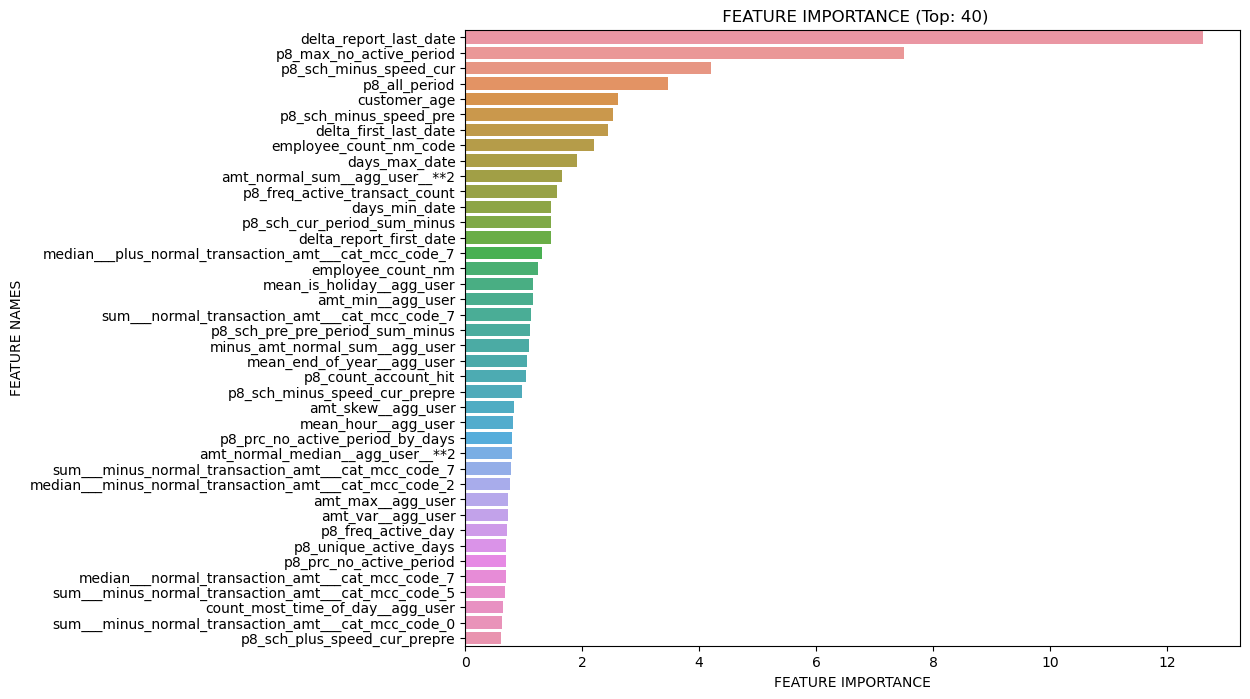

In [65]:
# Важность признаков
fi_df = plot_feature_importance(fold_model_reg.get_feature_importance(), fold_X_train.columns, model_name='', top_n=40)  

#### Заполняем time_predict для сабмита 

In [66]:
%%time
model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=100, iterations=600, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

CPU times: total: 2min 38s
Wall time: 29.7 s


In [67]:
X_submit['predict_time'] = model_reg.predict(X_submit[feature_columns])

C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\1941690059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit['predict_time'] = model_reg.predict(X_submit[feature_columns])


In [68]:
%%time
qnt_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7', 
                                       early_stopping_rounds=100, iterations=700, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
qnt_model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

CPU times: total: 11min 8s
Wall time: 1min 26s


In [69]:
X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
X_submit[qnt_columns] = np.sort(X_submit[qnt_columns].values)
X_submit

C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\94224397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\94224397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
C:\Users\Profit77\AppData\Local\Temp\ipykernel_7412\94224397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,uniq_mcc__agg_user,median___normal_transaction_amt___cat_mcc_code_4,count_most_season_of_year__agg_user,plus_amt_normal_min__agg_user,median___plus_normal_transaction_amt___cat_mcc_code_0,count_weekday__agg_user,delta_report_last_date,mean_is_holiday__agg_user,median___normal_transaction_amt___cat_mcc_code_7,customer_age,p8_sch_plus_speed_pre,count___normal_transaction_amt___cat_mcc_code_5,p8_count_account_hit,median___minus_normal_transaction_amt___cat_mcc_code_2,amt_normal_sum__agg_user,amt_normal_skew__agg_user,count___normal_transaction_amt___cat_mcc_code_4,count___plus_normal_transaction_amt___cat_mcc_code_7,sum___minus_normal_transaction_amt___cat_mcc_code_6,p8_count_account_charge,amt_std__agg_user,p8_sch_minus_speed_cur,count___normal_transaction_amt___cat_mcc_code_7,minus_amt_normal_median__agg_user,sum___minus_normal_transaction_amt___cat_mcc_code_0,main_count_transaction_amt_412,count___plus_normal_transaction_amt___cat_mcc_code_5,main_count_transaction_amt_338_norm,median___minus_normal_transaction_amt___cat_mcc_code_6,report,minus_amt_normal_max__agg_user,count___plus_normal_transaction_amt___cat_mcc_code_1,days_report_dt,p8_freq_active_transact_count,p8_active_period,count___minus_normal_transaction_amt___cat_mcc_code_4,most_time_of_day__agg_user,minus_amt_normal_std__agg_user,median___minus_normal_transaction_amt___cat_mcc_code_4,median___minus_normal_transaction_amt___cat_mcc_code_5,p8_sch_cur_period_sum_plus,p8_sch_cur_period_sum_minus,sum___normal_transaction_amt___cat_mcc_code_0,count___normal_transaction_amt___cat_mcc_code_0,sum___normal_transaction_amt___cat_mcc_code_6,amt_skew__agg_user,p8_sch_pre_pre_period_sum_plus,count___normal_transaction_amt___cat_mcc_code_2,median___normal_transaction_amt___cat_mcc_code_1,bankemplstatus,median___minus_normal_transaction_amt___cat_mcc_code_3,amt_normal_max__agg_user,p8_sch_plus_speed_cur_prepre,plus_amt_normal_skew__agg_user,sum___plus_normal_transaction_amt___cat_mcc_code_6,sum___minus_normal_transaction_amt___cat_mcc_code_5,count_most_weekday__agg_user,count___minus_normal_transaction_amt___cat_mcc_code_5,sum___minus_normal_transaction_amt___cat_mcc_code_2,p8_all_period,p8_prc_no_active_period_by_days,sum___plus_normal_transaction_amt___cat_mcc_code_4,skew_weekday__agg_user,sum___plus_normal_transaction_amt___cat_mcc_code_2,minus_amt_normal_var__agg_user,count___minus_normal_transaction_amt___cat_mcc_code_0,most_season_of_year__agg_user,main_median_transaction_amt_318,most_month__agg_user,minus_amt_normal_min__agg_user,main_sum_transaction_amt_412,sum___normal_transaction_amt___cat_mcc_code_5,main_sum_transaction_amt_364,count___plus_normal_transaction_amt___cat_mcc_code_0,median___plus_normal_transaction_amt___cat_mcc_code_4,amt_normal_sum__agg_user__**2,sum___normal_transaction_amt___cat_mcc_code_4,sum___plus_normal_transaction_amt___cat_mcc_code_3,plus_amt_normal_median__agg_user,minus_amt_normal_count__agg_user,delta_report_first_date,uniq_currency__agg_user,median___plus_normal_transaction_amt___cat_mcc_code_2,count___minus_normal_transaction_amt___cat_mcc_code_3,main_sum_transaction_amt_318,amt_min__agg_user,minus_amt_normal_skew__agg_user,amt_median__agg_user,amt_normal_count__agg_user,count_most_time_of_day__agg_user,count___normal_transaction_amt___cat_mcc_code_3,amt_normal_min__agg_user,main_count_transaction_amt_364,p8_max_no_active_period,plus_amt_normal_var__agg_user,median___normal_transaction_amt___cat_mcc_code_0,median___normal_transaction_amt___cat_mcc_code_6,delta_first_last_date,main_median_transaction_amt_338,sum___normal_transaction_amt___cat_mcc_code_1,count___normal_transaction_amt___cat_mcc_code_1,p8_sch_plus_speed_cur,median___plus_normal_transaction_amt___cat_mcc_code_3,count___plus_normal_transaction_amt___cat_mcc_code_2,main_median_transaction_amt_412,amt_var__agg_user,count_most_month__agg_user,days_min_date,main_sum_transaction_amt_338,minus_amt_normal_sum__agg_user,count___minus_normal_transaction_amt___cat_mcc_code_7,main_count_tra

# Модель Классификации

### Submit

In [75]:
clf_feature_columns = list(set(feature_columns + ['predict_time'] + qnt_columns) - set(['user_id_day_30_dima']))
len(clf_feature_columns)

183

In [76]:
target_column = 'target'
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

In [77]:
target_column = 'target'
res_X_train, res_y_train = train_df[clf_feature_columns], train_df[target_column]

res_X_test_submit = X_submit[clf_feature_columns]

res_X_train.shape, res_y_train.shape, res_X_test_submit.shape

((64000, 183), (64000,), (32000, 183))

In [82]:
# # Сохраняем итоговый набор фичей
train_df[clf_feature_columns + [target_column]].to_csv('features_X_train__v5_2.csv', index=False)
X_submit[clf_feature_columns].to_csv('features_X_test__v5_@.csv', index=False)

train_df[clf_feature_columns + [target_column]].shape, X_submit[clf_feature_columns].shape

((64000, 184), (32000, 183))

In [85]:
# embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

In [ ]:
%%time
# # model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2500, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])
# submit_model_clf = CatBoostClassifier(early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
# submit_model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
submit_model_clf = CatBoostClassifier(
                eval_metric="AUC", 
                early_stopping_rounds=300, 
                # iterations=3000, # 9
                # iterations=8000, # 9_2
                iterations=12000, # 9_3
                random_state=53, 
                cat_features=cat_features, 
                # embedding_features=embedding_features,
                learning_rate=0.01)
submit_model_clf.fit(res_X_train, res_y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]
res_X_test_submit[['user_id', 'predict']].to_csv('submit_v9_3.csv', index=False)
res_X_test_submit.shape